In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Install dependencies
Note: turn on GPU mode to start using CUDA, change runtime type to Python 3.

1. Keras 1.1.0
2. Theano 0.9.0
3. By default, latest CUDA installed. Downgrade to CUDA 8.0 for compatible purpose, modify GCC version accordingly.

In [0]:
!sudo apt-get install python-yaml -y
!sudo apt-get install libhdf5-serial-dev -y
!sudo pip install keras==1.1.0
!pip install theano==0.9.0
!pip install path.py

In [0]:
!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb;
!dpkg -i cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb;
!apt-key add /var/cuda-repo-8-0-local-ga2/7fa2af80.pub;
!apt-get update -qq;


In [0]:
!apt install g++-5
!update-alternatives --remove-all gcc 
!update-alternatives --remove-all g++

!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20

!update-alternatives --install /usr/bin/cc cc /usr/bin/gcc 30
!update-alternatives --set cc /usr/bin/gcc

!update-alternatives --install /usr/bin/c++ c++ /usr/bin/g++ 30
!update-alternatives --set c++ /usr/bin/g++

!sudo apt install cuda-8.0;

**cuDNN (v5.1):  a GPU-accelerated library of primitives for deep neural networks**

In [0]:
%cd /content
!wget http://developer.download.nvidia.com/compute/redist/cudnn/v5.1/cudnn-8.0-linux-x64-v5.1.tgz
!tar -xzvf cudnn-8.0-linux-x64-v5.1.tgz
!sudo cp -P cuda/include/cudnn.h /usr/local/cuda-8.0/include
!sudo cp -P cuda/lib64/libcudnn* /usr/local/cuda-8.0/lib64/
!sudo chmod a+r /usr/local/cuda-8.0/lib64/libcudnn*

In [0]:
!gcc --version
!nvcc -V

In [4]:
!nvidia-smi

Wed Jun 26 15:10:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    56W / 149W |     88MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install numpy==1.14.6 # downgrade to match the Theano version (if needed)

#Initialization

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
os.environ["KERAS_BACKEND"] = "theano"

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, TimeDistributedDense ,LSTM,Reshape
from keras.regularizers import l2
from keras.optimizers import SGD,adam, Adagrad
from scipy.io import loadmat, savemat
from keras.models import model_from_json
import theano.tensor as T
import theano
import csv
import configparser
import collections
import time
import csv
import os
from os import listdir
import skimage.transform
from skimage import color
from os.path import isfile, join
import numpy as np
import numpy
from datetime import datetime
import path
from os.path import basename
import glob
import matplotlib.pyplot as plt
import theano.sandbox
theano.sandbox.cuda.use('gpu0')
from IPython.display import clear_output
import math

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



**3 FC Layers**

In [7]:
print("Create Model")
model = Sequential()
model.add(Dense(512, input_dim=4096,init='glorot_normal',W_regularizer=l2(0.001),activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(32,init='glorot_normal',W_regularizer=l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(1,init='glorot_normal',W_regularizer=l2(0.001),activation='sigmoid'))
print(model.summary())

Create Model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           2097664     dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 32)            16416       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 32)            0           dense_2[0][0]                    
______________________________________________________________________________

In [9]:
# COUNT THE NUMBER OF VIDEO
!ls -l "/content/gdrive/My Drive/HumanBehaviors/C3D_Feature_txt/Train_RoadAccidents/Normal" | egrep -c '^-'
!ls -l "/content/gdrive/My Drive/HumanBehaviors/C3D_Feature_txt/Train_RoadAccidents/Abnormal" | egrep -c '^-'
!ls -l "/content/gdrive/My Drive/HumanBehaviors/C3D_Feature_txt/Test_RoadAccidents" | egrep -c '^-'

330
366
100


# Load and label video (0/1), implement objective function

1.   Utility functions: load/save model/weight, load video feature and make label (0/1) in batch size of 60.
2.   Objective function



In [0]:
def load_model(json_path):
    model = model_from_json(open(json_path).read())
    return model

def load_weights(model, weight_path): # Function to load the model weights
    dict2 = loadmat(weight_path)
    dict = conv_dict(dict2)
    i = 0
    for layer in model.layers:
        weights = dict[str(i)]
        layer.set_weights(weights)
        i += 1
    return model

def conv_dict(dict2):
    i = 0
    dict = {}
    for i in range(len(dict2)):
        if str(i) in dict2:
            if dict2[str(i)].shape == (0, 0):
                dict[str(i)] = dict2[str(i)]
            else:
                weights = dict2[str(i)][0]
                weights2 = []
                for weight in weights:
                    if weight.shape in [(1, x) for x in range(0, 5000)]:
                        weights2.append(weight[0])
                    else:
                        weights2.append(weight)
                dict[str(i)] = weights2
    return dict

def save_model(model, json_path, weight_path):
    json_string = model.to_json()
    open(json_path, 'w').write(json_string)
    dict = {}
    i = 0
    for layer in model.layers:
        weights = layer.get_weights()
        my_list = np.zeros(len(weights), dtype=np.object)
        my_list[:] = weights
        dict[str(i)] = my_list
        i += 1
    savemat(weight_path, dict)


# Load Training Dataset and label training videos

def load_dataset_Train_batch(AbnormalPath, NormalPath):

    batchsize=60            # Each batch contain 60 videos.
    n_exp=int(batchsize/2)  # 30 normal and 30 road accident videos

    Num_abnormal = 366  # number of road accident videos in Training set.
    Num_Normal = 330    # number of normal videos in Training set.


    # We assume the features of abnormal videos and normal videos are located in two different folders.
    Abnor_list_iter = np.random.permutation(Num_abnormal)
    Abnor_list_iter = Abnor_list_iter[Num_abnormal-n_exp:] # Indexes for randomly selected Abnormal Videos
    Norm_list_iter = np.random.permutation(Num_Normal)
    Norm_list_iter = Norm_list_iter[Num_Normal-n_exp:]     # Indexes for randomly selected Normal Videos

    AllVideos_Path = AbnormalPath
    def listdir_nohidden(AllVideos_Path):  # To ignore hidden files
        file_dir_extension = os.path.join(AllVideos_Path, '*_C.txt')
        for f in glob.glob(file_dir_extension):
            if not f.startswith('.'):
                yield os.path.basename(f)

    All_Videos=sorted(listdir_nohidden(AllVideos_Path))
    All_Videos.sort()
    AllFeatures = []  # To store C3D features of a batch
    print("Loading Abnormal videos Features...")

    Video_count=-1
    
    ###################### READ RANDOMLY ABNORMAL FEATURE 32x4096 #################
    for iv in Abnor_list_iter:
        Video_count=Video_count+1
        VideoPath = os.path.join(AllVideos_Path, All_Videos[iv])
        f = open(VideoPath, "r")
        words = f.read().split()
        num_feat = int(len(words) / 4096)
        # Number of features per video to be loaded.
        # In our case num_feat=32, as we divide the video into 32 segments. 

        count = -1;
        VideoFeatues = []
        for feat in range(0, num_feat):
            feat_row1 = np.float32(words[feat * 4096:feat * 4096 + 4096])
            count = count + 1
            if count == 0:
                VideoFeatues = feat_row1
            if count > 0:
                VideoFeatues = np.vstack((VideoFeatues, feat_row1))

        if Video_count == 0:
            AllFeatures = VideoFeatues
        if Video_count > 0:
            AllFeatures = np.vstack((AllFeatures, VideoFeatues))

        
        
    print("Loading Normal videos...")
    AllVideos_Path =  NormalPath

    def listdir_nohidden(AllVideos_Path):  # To ignore hidden files
        file_dir_extension = os.path.join(AllVideos_Path, '*_C.txt')
        for f in glob.glob(file_dir_extension):
            if not f.startswith('.'):
                yield os.path.basename(f)

    All_Videos = sorted(listdir_nohidden(AllVideos_Path))
    All_Videos.sort()

    for iv in Norm_list_iter:
        VideoPath = os.path.join(AllVideos_Path, All_Videos[iv])
        f = open(VideoPath, "r")
        words = f.read().split()
        feat_row1 = np.array([])
        num_feat = int(len(words) /4096)   
        # Number of features to be loaded. 
        # In our case num_feat=32, as we divide the video into 32 segments.

        count = -1;
        VideoFeatues = []
        for feat in range(0, num_feat):


            feat_row1 = np.float32(words[feat * 4096:feat * 4096 + 4096])
            count = count + 1
            if count == 0:
                VideoFeatues = feat_row1
            if count > 0:
                VideoFeatues = np.vstack((VideoFeatues, feat_row1))
            feat_row1 = []
        AllFeatures = np.vstack((AllFeatures, VideoFeatues))

    print("Features  loaded")


    AllLabels = np.zeros(32*batchsize, dtype='uint8') 
    # 60*32 = 1920 label, 0/1 (INTEGER, please remember, regression init)
    
    th_loop1=n_exp*32
    th_loop2=n_exp*32-1
    
    # mini-batch size = 60, 30 normals, 30 abnormals
    # --> 30*32= 640 feature vectors for 32 segments and 30 videos


    # Load Abnormal path fist--> index 0-639 is assigned value 0,
    # remains 640 from th_loop2 = 640-1920 to label 1
    
    for iv in range(0, 32*batchsize): # 1920
            if iv< th_loop1:
                AllLabels[iv] = int(0)  # All instances of abnormal videos are labeled 0.  This will be used in custom_objective to keep track of normal and abnormal videos indexes.
            if iv > th_loop2:
                AllLabels[iv] = int(1)   # All instances of Normal videos are labeled 1. This will be used in custom_objective to keep track of normal and abnormal videos indexes.

          # There are 1920 labels in total (all instances 32segment*60video a batch)
          
    return  AllFeatures,AllLabels



**Objective function**

In [0]:

def custom_objective(y_true, y_pred):
  
    y_true = T.flatten(y_true)
    y_pred = T.flatten(y_pred)
    n_seg = 32  
    nvid = 60
    n_exp = int(nvid / 2)
    Num_d=32*nvid


    sub_max = T.ones_like(y_pred) # sub_max represents the highest scoring instants in bags (videos).
    sub_sum_labels = T.ones_like(y_true) # It is used to sum the labels in order to distinguish between normal and abnormal videos.
    sub_sum_l1=T.ones_like(y_true)  # For holding the concatenation of summation of scores in the bag.
    sub_l2 = T.ones_like(y_true) # For holding the concatenation of L2 of score in the bag.
    
    
    for ii in range(0, nvid, 1):
        # For Labels
        mm = y_true[ii * n_seg:ii * n_seg + n_seg]
        sub_sum_labels = T.concatenate([sub_sum_labels, T.stack(T.sum(mm))])  # Just to keep track of abnormal and normal vidoes
        
        # For Features scores
        Feat_Score = y_pred[ii * n_seg:ii * n_seg + n_seg]
        sub_max = T.concatenate([sub_max, T.stack(T.max(Feat_Score))])         # Keep the maximum score of scores of all instances in a Bag (video)
        sub_sum_l1 = T.concatenate([sub_sum_l1, T.stack(T.sum(Feat_Score))])   # Keep the sum of scores of all instances in a Bag (video)
        
        z1 = T.ones_like(Feat_Score)
        z2 = T.concatenate([z1, Feat_Score])
        z3 = T.concatenate([Feat_Score, z1])
        z_22 = z2[31:]
        z_44 = z3[:33]
        z = z_22 - z_44
        z = z[1:32]
        z = T.sum(T.sqr(z))
        sub_l2 = T.concatenate([sub_l2, T.stack(z)])

    # sub_max[Num_d:] means include all elements after Num_d.
    # AllLabels =[2 , 4, 3 ,9 ,6 ,12,7 ,18 ,9 ,14]
    # z=x[4:]
    #[  6.  12.   7.  18.   9.  14.]

    sub_score = sub_max[Num_d:]  # We need this step since we have used T.ones_like
    F_labels = sub_sum_labels[Num_d:] # We need this step since we have used T.ones_like
    #  F_labels contains integer 32 for normal video and 0 for abnormal videos. This because of labeling done at the end of "load_dataset_Train_batch"



    # AllLabels =[2 , 4, 3 ,9 ,6 ,12,7 ,18 ,9 ,14]
    # z=x[:4]
    # [ 2 4 3 9]... This shows 0 to 3 elements

    sub_sum_l1 = sub_sum_l1[Num_d:] # We need this step since we have used T.ones_like
    sub_sum_l1 = sub_sum_l1[:n_exp]
    sub_l2 = sub_l2[Num_d:]         # We need this step since we have used T.ones_like
    sub_l2 = sub_l2[:n_exp]


    indx_nor = theano.tensor.eq(F_labels, 32).nonzero()[0]  # Index of normal videos: Since we labeled 1 for each of 32 segments of normal videos F_labels=32 for normal video
    indx_abn = theano.tensor.eq(F_labels, 0).nonzero()[0]

    n_Nor=n_exp

    Sub_Nor = sub_score[indx_nor] # Maximum Score for each of abnormal video
    Sub_Abn = sub_score[indx_abn] # Maximum Score for each of normal video

    z = T.ones_like(y_true)
    for ii in range(0, n_Nor, 1):
        sub_z = T.maximum(1 - Sub_Abn + Sub_Nor[ii], 0) + T.maximum(0, Sub_Nor[ii] - T.log2(Sub_Abn))
        z = T.concatenate([z, T.stack(T.sum(sub_z))])

    z = z[Num_d:]  # We need this step since we have used T.ones_like
    z = T.mean(z, axis=-1) +  0.00008*T.sum(sub_sum_l1) + 0.00008*T.sum(sub_l2)  # Final Loss f
    
    return z # this is y_predicted tensor, the return of loss function


# Training code
**Train on batch, size of 60, save model's weight after each 1000 iterations.**


1.   Input: specify video feature (txt file) directory (Normal and Abnormal); directory to save the weight;
2.   Output: model's weight (*.mat file). In addition, plot the loss value in every batch after 20 iterations.



Loading Abnormal videos Features...
Loading Normal videos...
Features  loaded
------------------- TRAIN ON BATCH- iteration  221


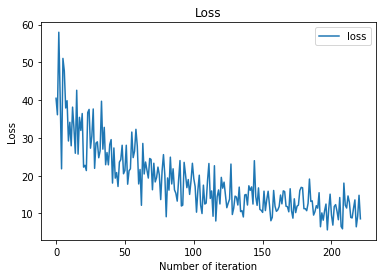

Loading Abnormal videos Features...
Loading Normal videos...
Features  loaded
------------------- TRAIN ON BATCH- iteration  222


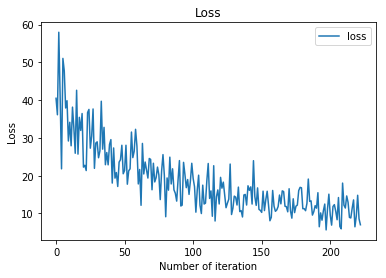

Loading Abnormal videos Features...
Loading Normal videos...
Features  loaded
------------------- TRAIN ON BATCH- iteration  223


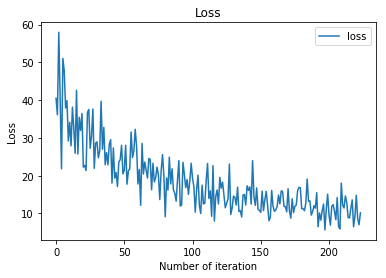

Loading Abnormal videos Features...
Loading Normal videos...
Features  loaded
------------------- TRAIN ON BATCH- iteration  224


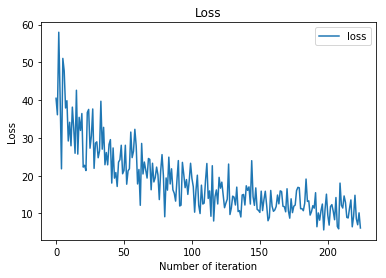

Loading Abnormal videos Features...
Loading Normal videos...


KeyboardInterrupt: ignored

In [18]:
adagrad=Adagrad(lr=0.01, epsilon=1e-08)

model.compile(loss=custom_objective, optimizer=adagrad)

print("Starting training...")

AllClassPath='/content/gdrive/My Drive/HumanBehaviors/C3D_Feature_txt/Train_RoadAccidents/'
# AllClassPath contains C3D features (.txt file)  of each video. Each text file contains 32 features, each of 4096 dimension
output_dir='/content/gdrive/My Drive/HumanBehaviors/Result/Weight/'
# Output_dir is the directory where you want to save trained weights

loss_dir = 'content/gdrive/My Drive/HumanBehaviors/Result/Loss' # to save figure
weights_path = output_dir + 'weights.mat'
# weights.mat are the model weights that you will get after (or during) that training
model_path = output_dir + 'model.json'

if not os.path.exists(output_dir):
       os.makedirs(output_dir)
    
if not os.path.exists(loss_dir):
       os.makedirs(loss_dir)
    
All_class_files= listdir(AllClassPath)
All_class_files.sort()
loss_graph =[]
num_iters = 10000
total_iterations = 0
batchsize=60
time_before = datetime.now()

for it_num in range(num_iters):

    AbnormalPath = os.path.join(AllClassPath, All_class_files[0])  # Path of abnormal already computed C3D features
    NormalPath = os.path.join(AllClassPath, All_class_files[1])    # Path of Normal already computed C3D features
    inputs, targets=load_dataset_Train_batch(AbnormalPath, NormalPath)  # Load normal and abnormal video C3D features
    # INPUTS: (1920x4096)
    # Targets (1920,) (32*60 video)
    # INPUT: 
    #   1/ A BATCH of 1920 feature vector (4096d) for each segment, 810 abnormal, 798 normal
    #   2/ LABEL of 1920 segments, integer value 0/1 (regression)
    
    print("------------------- TRAIN ON BATCH- iteration ", it_num)
    batch_loss =model.train_on_batch(inputs, targets)
    loss_graph = np.hstack((loss_graph, batch_loss)) #put to stack of numpy array
    total_iterations += 1
    
    # PLOT THE LOSS
    plt.plot(loss_graph, label='loss')
    plt.title('Loss')
    plt.legend()
    plt.xlabel('Number of iteration')
    plt.ylabel('Loss')
    
    if total_iterations % 20 == 1:
      plt.savefig(loss_dir + 'loss_' + str(total_iterations) +'.png')
      print("These iteration=" + str(total_iterations) + ") took: " + str(datetime.now() - time_before) + ", with loss of " + str(batch_loss))
    plt.show()
      
    if total_iterations % 20 == 1:
        iteration_path = output_dir + 'Iterations_graph_' + str(total_iterations) + '.mat'
        savemat(iteration_path, dict(loss_graph=loss_graph))
        clear_output()
    if total_iterations % 1000 == 0:  # Save the model at every 1000th iterations.
       weights_path = output_dir + 'weights_AllLoss2_L1L2_' + str(total_iterations) + '.mat'
       save_model(model, model_path, weights_path)

save_model(model, model_path, weights_path)

# Testing
**Predict the score for each segment within a video on Testing set**


1.   Input: model's weight (*.mat file), specify the directory of testing video feauture (100 videos)
2.   Output: .*mat file, each file corresponds to each video score. A video score is a vector of 32-d, each value is abnormal score of each video segments.



In [23]:
seed = 7
numpy.random.seed(seed)


def load_model(json_path):  # Function to load the model
    model = model_from_json(open(json_path).read())
    return model

def load_weights(model, weight_path):  # Function to load the model weights
    dict2 = loadmat(weight_path)
    dict = conv_dict(dict2)
    i = 0
    for layer in model.layers:
        weights = dict[str(i)]
        layer.set_weights(weights)
        i += 1
    return model

def conv_dict(dict2):
    i = 0
    dict = {}
    for i in range(len(dict2)):
        if str(i) in dict2:
            if dict2[str(i)].shape == (0, 0):
                dict[str(i)] = dict2[str(i)]
            else:
                weights = dict2[str(i)][0]
                weights2 = []
                for weight in weights:
                    if weight.shape in [(1, x) for x in range(0, 5000)]:
                        weights2.append(weight[0])
                    else:
                        weights2.append(weight)
                dict[str(i)] = weights2
    return dict

# Load Video

def load_dataset_One_Video_Features(Test_Video_Path):

    VideoPath =Test_Video_Path
    f = open(VideoPath, "r")
    words = f.read().split()
    num_feat = int(len(words) / 4096)
    # Number of features per video to be loaded. In our case num_feat=32, as we divide the video into 32 segments. Note that
    # we have already computed C3D features for the whole video and divided the video features into 32 segments.

    count = -1;
    VideoFeatues = []
    for feat in range(0, num_feat):
        feat_row1 = np.float32(words[feat * 4096:feat * 4096 + 4096])
        count = count + 1
        if count == 0:
            VideoFeatues = feat_row1
        if count > 0:
            VideoFeatues = np.vstack((VideoFeatues, feat_row1))
    AllFeatures = VideoFeatues

    return  AllFeatures



print("Starting testing...")


AllTest_Video_Path = '/content/gdrive/My Drive/HumanBehaviors/C3D_Feature_txt/Test_RoadAccidents/'
# AllTest_Video_Path contains C3D features (txt file)of each video.

Results_Path = '/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/'
# Results_Path is the folder where you can save your results

Model_dir='/content/gdrive/My Drive/HumanBehaviors/Result/Weight/'
# Model_dir is the folder where we have placed our trained weights

weights_path = Model_dir + 'weights_ALL_L1L2_10000.mat'
# weights_path is Trained model weights

model_path = Model_dir + 'model.json'

if not os.path.exists(Results_Path):
       os.makedirs(Results_Path)

All_Test_files= listdir(AllTest_Video_Path)
All_Test_files.sort()

model=load_model(model_path)
load_weights(model, weights_path)
nVideos=len(All_Test_files)
time_before = datetime.now()

for iv in range(nVideos):

    Test_Video_Path = os.path.join(AllTest_Video_Path, All_Test_files[iv])
    inputs=load_dataset_One_Video_Features(Test_Video_Path) # 32 segments features for one testing video
    predictions = model.predict_on_batch(inputs)   # Get anomaly prediction for each of 32 video segments.
    aa=All_Test_files[iv]
    aa=aa[0:-6]
    A_predictions_path = Results_Path + aa + '.mat'  # Save array of 1*32, containing anomaly score for each segment. Please see Evaluate Anomaly Detector to compute  ROC.
    savemat(A_predictions_path, dict(predictions = predictions))
    print (A_predictions_path)
    print ("Total Time took: " + str(datetime.now() - time_before))

Starting testing...
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_006_x264.mat
Total Time took: 0:00:09.286617
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_033_x264.mat
Total Time took: 0:00:09.899443
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_034_x264.mat
Total Time took: 0:00:10.564729
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_050_x264.mat
Total Time took: 0:00:11.045334
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_051_x264.mat
Total Time took: 0:00:11.470535
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_1000_x264.mat
Total Time took: 0:00:11.931150
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_1010_x264.mat
Total Time took: 0:00:12.365546
/content/gdrive/My Drive/HumanBehaviors/Result/PredictedScore/Normal_Videos_168_x264.mat
Total Time took: 0:00:12.844717
/content/g